In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from glob import glob
from PIL import Image

# Set constants
IMAGE_SIZE = 64
CHANNELS = 3
BUFFER_SIZE = 60000
BATCH_SIZE = 128
LATENT_DIM = 100

2025-05-19 14:38:31.270190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747665511.464379      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747665511.522883      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Dataset path
data_path = "/kaggle/input/anime-face-dataset-ntumlds/images/*.jpg"

def load_images(path):
    all_images = []
    for filename in glob(path):
        img = Image.open(filename).resize((IMAGE_SIZE, IMAGE_SIZE))
        img = np.asarray(img)
        if img.shape == (64, 64, 3):  # Filter out any corrupted images
            all_images.append(img)
    return np.array(all_images)

anime_faces = load_images(data_path)
anime_faces = (anime_faces.astype(np.float32) - 127.5) / 127.5


# Create TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(anime_faces)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

I0000 00:00:1747665655.100476      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [3]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(4*4*1024, use_bias=False, input_shape=(LATENT_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((4, 4, 1024)),

        layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = build_discriminator()

In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)  # label smoothing
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + 0.1, fake_output)  # noisy fake labels
    return real_loss + fake_loss


generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [6]:
import time
from IPython.display import clear_output

EPOCHS = 150
NUM_EXAMPLES_TO_GENERATE = 16
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, LATENT_DIM])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2.0  # Denormalize to [0,1]

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'anime_faces_epoch_{epoch}.png')
    plt.show()

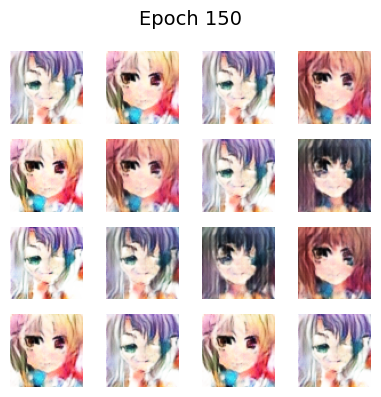

Time for epoch 150 is 40.81 sec


In [7]:
def train(dataset, epochs):
    for epoch in range(1, epochs + 1):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        clear_output(wait=True)
        generate_and_save_images(generator, epoch, seed)

        print(f'Time for epoch {epoch} is {time.time()-start:.2f} sec')

train(train_dataset, EPOCHS)